# Import Necessary Libraries

In [1]:
import numpy as np # Linear algebra
import os
import matplotlib.pyplot as plt # ploting library for simple plots

import cv2
from tqdm import tqdm
import io
import seaborn as sns # ploting utility

from sklearn.utils import shuffle # Shuffle arrays or sparse matrices in a consistent way
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, TensorBoard,ModelCheckpoint

from sklearn.metrics import classification_report, confusion_matrix
from keras.utils.vis_utils import plot_model

import ipywidgets as widgets
from PIL import Image
from IPython.display import display, clear_output

# Labels in order of severity

In [2]:
labels = ['CONTROL', 'AD', 'PD']

# What is tqdm?
<br><br>
1. tqdm is a Python library that allows you to output a smart progress bar by wrapping around any iterable. 
<br><br>
2. A tqdm progress bar not only shows you how much time has elapsed, but also shows the estimated time remaining for the iterable.
<br><br>
3. Resulting tqdm progress bar gives us information that includes the task completion percentage, number of iterations complete, time elapsed, estimated time remaining, and the iterations completed per second.


In [3]:
X_train = [] #Training Dataset
Y_train = [] #Training Labels

image_size=150

for i in labels:
    folderPath = os.path.join('Datasets/alzheimer-diseases-3-class/3_cls/', 'train', i)
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)
        
        
for i in labels:
    folderPath = os.path.join('Datasets/alzheimer-diseases-3-class/3_cls/', 'test', i) # Join two or more pathname components
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)
        
#Image and Label is appended as list, now is to be converted into array
X_train = np.array(X_train)
Y_train = np.array(Y_train)

100%|██████████| 61/61 [00:00<00:00, 116.08it/s]


In [4]:
X_train.shape #No of sample = 7839

(7839, 150, 150, 3)

In [5]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)

In [6]:
#After shuffling sample size remains same
X_train.shape

(7839, 150, 150, 3)

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

# Converting String Label to categorical

In [8]:
y_train_new = []
y_test_new = []

for i in Y_train:
    y_train_new.append(labels.index(i))#Converting String Label to integer i.e
                                       # CONTROL ---> 0, AD---> 1, PD ---> 2
Y_train = to_categorical(y_train_new) #Converts a class vector (integers) to binary class matrix

for i in Y_test:
    y_test_new.append(labels.index(i))

Y_test = to_categorical(y_test_new)

In [9]:
Y_train

array([[0., 1., 0.],
       [0., 1., 0.],
       [1., 0., 0.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]], dtype=float32)

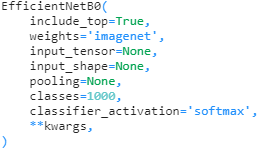

In [10]:
# Input of model
efficientnet_B0 = EfficientNetB0(include_top=False,
    weights='imagenet',
    input_shape=(image_size, image_size, 3))

2022-12-11 10:56:46.010658: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 10:56:46.011684: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 10:56:46.335830: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 10:56:46.337074: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-11 10:56:46.338227: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

16719872/16705208 [==============================] - 0s 0us/step


In [11]:
# Output of model
model = efficientnet_B0.output
model = tf.keras.layers.GlobalAveragePooling2D()(model)
model = tf.keras.layers.Dropout(0.5)(model)
model = tf.keras.layers.Dense(3, activation='softmax')(model)

In [12]:
#Merge input and Output of model
model = tf.keras.models.Model(inputs=efficientnet_B0.input, outputs=model)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 150, 150, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
normalization (Normalization)   (None, 150, 150, 3)  7           rescaling[0][0]                  
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, 151, 151, 3)  0           normalization[0][0]              
______________________________________________________________________________________________

In [13]:
#Configures the model for training
model.compile(optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc'])

# TensorBoard
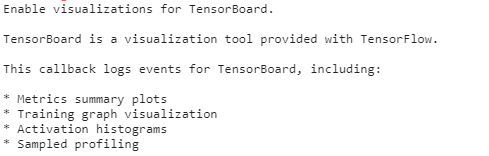

# ModelCheckpoint
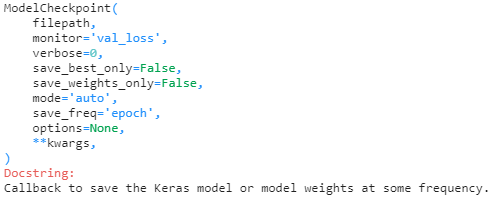

# Verbose
verbose: 'auto', 0, 1, or 2. Verbosity mode. 0 = silent, 1 = progress bar, 2 = one line per epoch. 'auto' defaults to 1 for most cases

# ReduceLROnPlateau
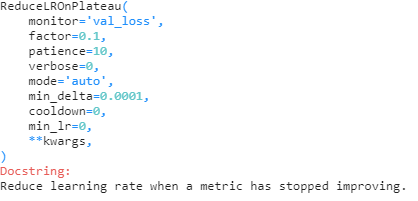
<br>
1. Models often benefit from reducing the learning rate by a factor
of 2-10 once learning stagnates. 
<br>
2. This callback monitors a quantity and if no improvement is seen for a 'patience' number
of epochs, the learning rate is reduced.
<br>
3. monitor: quantity to be monitored.
<br>
4. factor: factor by which the learning rate will be reduced.
<br>
       <b> new_lr = lr * factor`. </b>
<br>
5. patience: number of epochs with no improvement after which learning rate
      will be reduced.
<br>
6. min_delta: threshold for measuring the new optimum, to only focus on
      significant changes.

# EarlyStopping
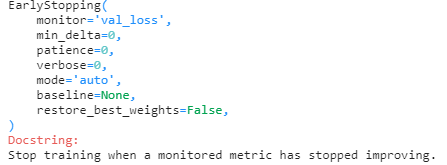

In [14]:
tensorBoard = TensorBoard(log_dir="logs")
checkPoint = ModelCheckpoint("efficient_net_B0.h5",
                            monitor='val_loss',
                            verbose=1,
                            save_best_only=True,
                            mode='auto')
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                             factor=0.3,
                             patience=2,
                             verbose=1,
                             mode='auto',
                             min_delta=0.001)
es = EarlyStopping(monitor='val_loss',
                   patience=5,
                   verbose=1,
                   mode='auto',
                   restore_best_weights=True) 

2022-12-11 10:56:53.625398: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-11 10:56:53.625451: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.
2022-12-11 10:56:53.628510: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1614] Profiler found 2 GPUs
2022-12-11 10:56:54.198261: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-11 10:56:54.198444: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed


In [15]:
history = model.fit(X_train, 
                    Y_train,
                    batch_size=32,
                    validation_split=0.1,
                    epochs=20,
                    verbose=1,
                    callbacks=[tensorBoard, checkPoint, reduce_lr, es])

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)
2022-12-11 10:56:55.438118: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20


2022-12-11 10:57:05.099170: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


  1/199 [..............................] - ETA: 1:08:29 - loss: 1.0685 - acc: 0.5938

2022-12-11 10:57:16.504503: I tensorflow/core/profiler/lib/profiler_session.cc:131] Profiler session initializing.
2022-12-11 10:57:16.504556: I tensorflow/core/profiler/lib/profiler_session.cc:146] Profiler session started.


  2/199 [..............................] - ETA: 3:49 - loss: 1.0538 - acc: 0.5000   

2022-12-11 10:57:17.447432: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2022-12-11 10:57:17.450186: I tensorflow/core/profiler/internal/gpu/cupti_tracer.cc:1748] CUPTI activity buffer flushed
2022-12-11 10:57:17.668239: I tensorflow/core/profiler/internal/gpu/cupti_collector.cc:673]  GpuTracer has collected 2024 callback api events and 2021 activity events. 
2022-12-11 10:57:17.762756: I tensorflow/core/profiler/lib/profiler_session.cc:164] Profiler session tear down.
2022-12-11 10:57:17.889231: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_12_11_10_57_17

2022-12-11 10:57:17.944866: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for trace.json.gz to logs/train/plugins/profile/2022_12_11_10_57_17/7bd3ccd79806.trace.json.gz


  3/199 [..............................] - ETA: 3:18 - loss: 0.9603 - acc: 0.5521

2022-12-11 10:57:18.103398: I tensorflow/core/profiler/rpc/client/save_profile.cc:136] Creating directory: logs/train/plugins/profile/2022_12_11_10_57_17

2022-12-11 10:57:18.116130: I tensorflow/core/profiler/rpc/client/save_profile.cc:142] Dumped gzipped tool data for memory_profile.json.gz to logs/train/plugins/profile/2022_12_11_10_57_17/7bd3ccd79806.memory_profile.json.gz
2022-12-11 10:57:18.123759: I tensorflow/core/profiler/rpc/client/capture_profile.cc:251] Creating directory: logs/train/plugins/profile/2022_12_11_10_57_17
Dumped tool data for xplane.pb to logs/train/plugins/profile/2022_12_11_10_57_17/7bd3ccd79806.xplane.pb
Dumped tool data for overview_page.pb to logs/train/plugins/profile/2022_12_11_10_57_17/7bd3ccd79806.overview_page.pb
Dumped tool data for input_pipeline.pb to logs/train/plugins/profile/2022_12_11_10_57_17/7bd3ccd79806.input_pipeline.pb
Dumped tool data for tensorflow_stats.pb to logs/train/plugins/profile/2022_12_11_10_57_17/7bd3ccd79806.tensorflow_stats.

199/199 [==============================] - 56s 179ms/step - loss: 0.5741 - acc: 0.7270 - val_loss: 0.7474 - val_acc: 0.6091

Epoch 00001: val_loss improved from inf to 0.74740, saving model to efficient_net_B0.h5
Epoch 2/20
199/199 [==============================] - 31s 157ms/step - loss: 0.3279 - acc: 0.8567 - val_loss: 0.3156 - val_acc: 0.8513

Epoch 00002: val_loss improved from 0.74740 to 0.31556, saving model to efficient_net_B0.h5
Epoch 3/20
199/199 [==============================] - 31s 157ms/step - loss: 0.2034 - acc: 0.9148 - val_loss: 0.2337 - val_acc: 0.8994

Epoch 00003: val_loss improved from 0.31556 to 0.23375, saving model to efficient_net_B0.h5
Epoch 4/20
199/199 [==============================] - 32s 161ms/step - loss: 0.1377 - acc: 0.9463 - val_loss: 0.2167 - val_acc: 0.9193

Epoch 00004: val_loss improved from 0.23375 to 0.21667, saving model to efficient_net_B0.h5
Epoch 5/20
199/199 [==============================] - 33s 165ms/step - loss: 0.1103 - acc: 0.9576 - val

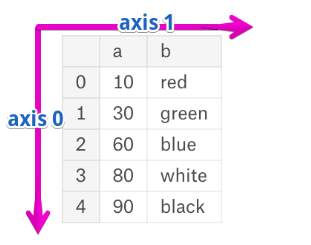

In [16]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
actual_label = np.argmax(Y_test, axis=1)
print(classification_report(actual_label, pred))

              precision    recall  f1-score   support

           0       0.97      0.98      0.97       360
           1       0.99      0.99      0.99       317
           2       0.96      0.93      0.94       107

    accuracy                           0.98       784
   macro avg       0.97      0.96      0.97       784
weighted avg       0.98      0.98      0.98       784



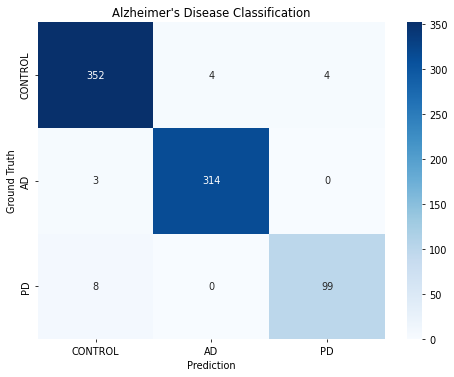

In [17]:
cnf = confusion_matrix(actual_label, pred)
plt.figure(figsize=(8,6), dpi=70, facecolor='w', edgecolor='k')
ax = sns.heatmap(cnf, cmap='Blues',annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
plt.title('Alzheimer\'s Disease Classification')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show(ax)

# plot_model
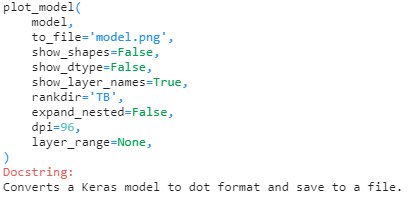

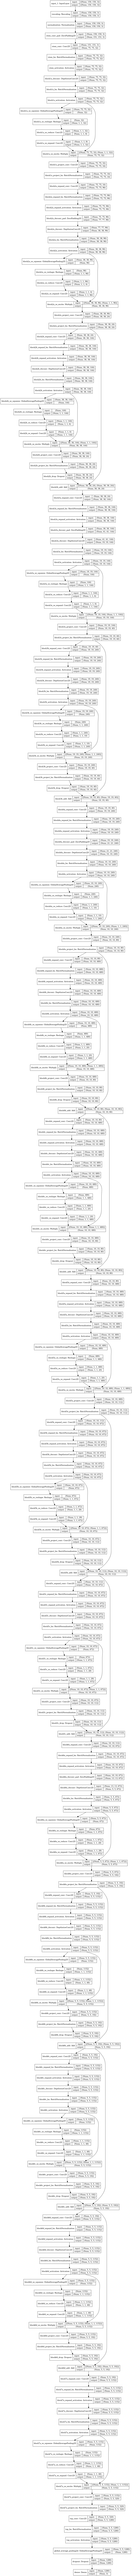

In [18]:
saved_model = tf.keras.models.load_model("./efficient_net_B0.h5")

#Show Model Architecture
plot_model(saved_model,
          to_file='efficient_net_B0.png',
          show_shapes=True,
          show_layer_names=True)

# Uploading Image and Showing its Class

1. BytesIO is used to read locally stored image
2. FileUpload() ---> Upload file(s) from browser to Python kernel as bytes
3. <b>display</b>
<br>
    a. Display a Python object in all frontends.
<br>
    b. By default all representations will be computed and sent to the frontends.
<br>
    c. Frontends can decide which representation is used and how.
4. <b>Button widget</b>
   <br>
   This widget has an `on_click` method that allows you to listen for the user clicking on the button
5. <b> Output </b> 
   <br>
Widget used as a context manager to display output
6. <b> clear_output() </b>
   <br>
   Clear the output of the current cell receiving output
7. <b> on_click()</b>
<br>
Register a callback to execute when the button is clicked.
8. <b> VBox</b>
<br>
Displays multiple widgets vertically using the flexible box model

In [19]:
def imagePrediction(upload):
    for name, fileinfo  in uploader.value.items():
        image = Image.open(io.BytesIO(fileinfo['content']))
        
    images = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
    images = cv2.resize(images,(150, 150))
    images = images.reshape(1, 150, 150, 3)
    prd = model.predict(images)
    prd = np.argmax(prd, axis = 1)[0]
    
    
    if prd == 0:
        prd = "CONTROL"
    elif prd == 1:
        prd = "AD"
    elif prd ==2:
        prd = "PD"
        
    print(f'Model Predict That is  a {prd}')

In [20]:
uploader = widgets.FileUpload()
display(uploader)

FileUpload(value={}, description='Upload')

In [21]:
button = widgets.Button(description= "Predict")
out = widgets.Output()

def on_button_click(_):
    with out:
        clear_output()
        try:
            imagePrediction(uploader)
        except:
            print("Please Enter the Correct Image files")
            
            
button.on_click(on_button_click)
widgets.VBox([button, out])